<a href="https://colab.research.google.com/github/muhammadthaufik10315/Deeplearning_Klasifikasi_Wajah_Moi_2-Efficientnet-/blob/main/Epoach%2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U --pre efficientnet
from efficientnet.tfkeras import EfficientNetB1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


In [3]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
path = "/content/drive/MyDrive/split_data/suku7/train"
lists_dir = os.listdir(path)
categories = []
file_name = []
for folder in lists_dir:
    files = os.listdir(path +"/"+folder)
    for file in files:
        path_file = path + "/" + folder + "/" + file
        file_name.append(path_file)
        categories.append(folder)

df = {"image": file_name,"categories": categories}
data = pd.DataFrame(df, index = None)
data = data.sample(frac=1)
data.head(5)

,image,categories
273,/content/drive/MyDrive/split_data/suku7/train/...,moi
327,/content/drive/MyDrive/split_data/suku7/train/...,moi
474,/content/drive/MyDrive/split_data/suku7/train/...,moi
122,/content/drive/MyDrive/split_data/suku7/train/...,rajaampat
137,/content/drive/MyDrive/split_data/suku7/train/...,rajaampat


In [5]:
path_datatest = "/content/drive/MyDrive/split_data/suku7/test"
lists_dir_datatest = os.listdir(path_datatest)
categories_datatest = []
file_name_datatest = []
for folder in lists_dir_datatest:
    files = os.listdir(path_datatest +"/"+folder)
    for file in files:
        path_file = path_datatest + "/" + folder + "/" + file
        file_name_datatest.append(path_file)
        categories_datatest.append(folder)

df_datatest = {"image": file_name_datatest,"categories":categories_datatest}
data_datatest = pd.DataFrame(df_datatest, index = None)
data_datatest = data_datatest.sample(frac=1)
nb_samples=data_datatest.shape[0]
data_datatest

,image,categories
51,/content/drive/MyDrive/split_data/suku7/test/m...,moi
82,/content/drive/MyDrive/split_data/suku7/test/m...,moi
68,/content/drive/MyDrive/split_data/suku7/test/m...,moi
132,/content/drive/MyDrive/split_data/suku7/test/r...,rajaampat
146,/content/drive/MyDrive/split_data/suku7/test/r...,rajaampat
...,...,...
86,/content/drive/MyDrive/split_data/suku7/test/m...,moi
149,/content/drive/MyDrive/split_data/suku7/test/r...,rajaampat
40,/content/drive/MyDrive/split_data/suku7/test/m...,moi
34,/content/drive/MyDrive/split_data/suku7/test/m...,moi


<Axes: >

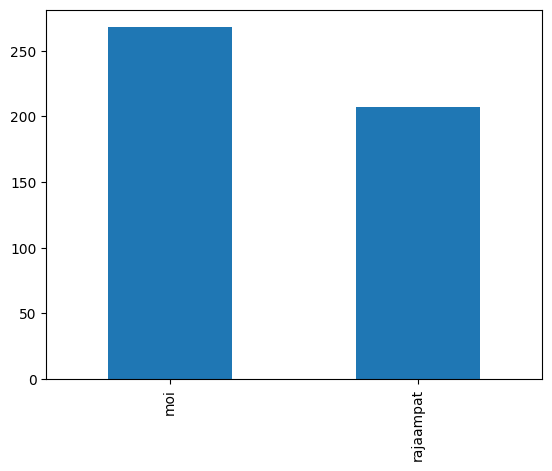

In [6]:
data['categories'].value_counts().plot.bar()

In [7]:
total_dataset=len(data_datatest)+len(data)
"Total dataset Suku :{} Suku".format(total_dataset)

'Total dataset Suku :635 Suku'

In [8]:
data["categories"] = data["categories"].replace({0: 'MOI', 1: 'RAJA AMPAT'})

In [9]:
train_df, validate_df = train_test_split(data, test_size=0.10, random_state=30)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

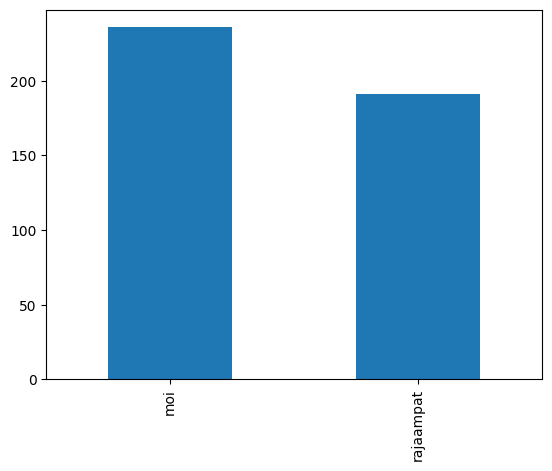

In [10]:
train_df['categories'].value_counts().plot.bar()

In [11]:
len(train_df)

427

<Axes: >

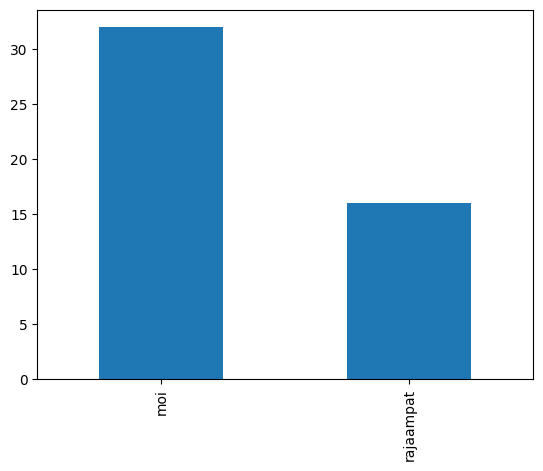

In [12]:
validate_df['categories'].value_counts().plot.bar()

In [13]:
len(validate_df)

48

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.1,
    vertical_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 427 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=path,
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 48 validated image filenames belonging to 2 classes.


In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    dataframe=example_df,
    dir=path,
    x_col='image',
    y_col='categories',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


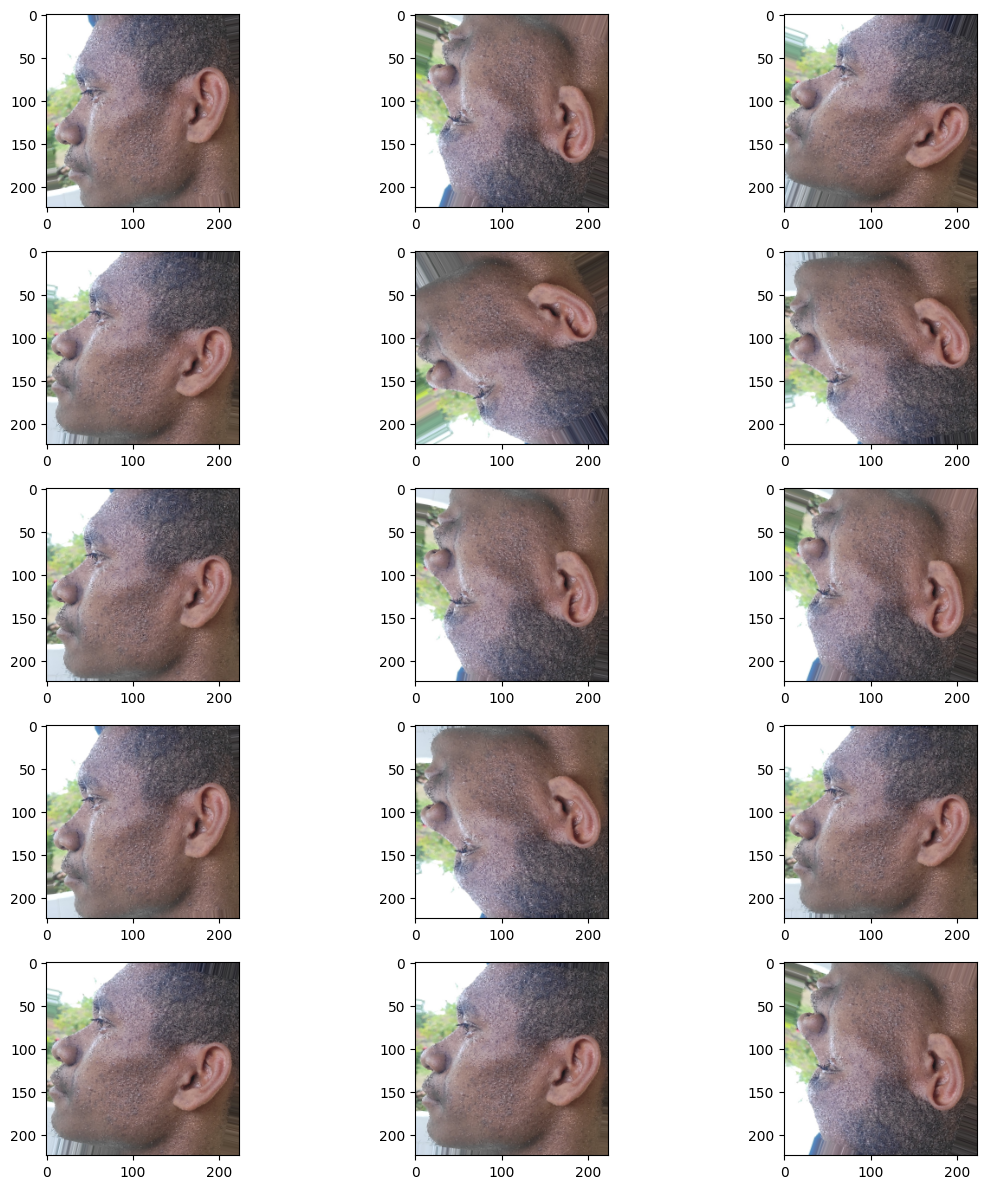

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [19]:
base_model = EfficientNetB1(input_shape=(224,224,3),
                                 include_top=False,
                                 weights='noisy-student')

27010080/27010080 [==============================] - 0s 0us/step


In [20]:
for layer in base_model.layers:
    layer.trainable=False

In [21]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(640,kernel_size=(1,1)))
model.add(Flatten())
model.add(Dense(320,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(tensorflow.keras.layers.ReLU())
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

In [22]:
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functiona  (None, 7, 7, 1280)        6575232   
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 640)         819840    
                                                                 
 flatten (Flatten)           (None, 31360)             0         
                                                                 
 dense (Dense)               (None, 320)               10035520  
                                                                 
 batch_normalization (Batch  (None, 320)               1280      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 320)               0

In [23]:
epochs=20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/20
13/13 [==============================] - 102s 5s/step - loss: 1.4804 - accuracy: 0.5646 - val_loss: 11.6295 - val_accuracy: 0.3750
Epoch 2/20
13/13 [==============================] - 12s 955ms/step - loss: 0.7452 - accuracy: 0.7332 - val_loss: 4.5100 - val_accuracy: 0.5312
Epoch 3/20
13/13 [==============================] - 12s 944ms/step - loss: 0.5197 - accuracy: 0.7949 - val_loss: 2.3950 - val_accuracy: 0.5312
Epoch 4/20
13/13 [==============================] - 12s 953ms/step - loss: 0.4114 - accuracy: 0.8101 - val_loss: 1.5459 - val_accuracy: 0.6562
Epoch 5/20
13/13 [==============================] - 13s 948ms/step - loss: 0.3778 - accuracy: 0.8173 - val_loss: 1.9350 - val_accuracy: 0.5938
Epoch 6/20
13/13 [==============================] - 13s 987ms/step - loss: 0.3541 - accuracy: 0.8203 - val_loss: 0.8720 - val_accuracy: 0.7812
Epoch 7/20
13/13 [==============================] - 11s 860ms/step - loss: 0.3695 - accuracy: 0.8438 - val_loss: 0.7283 - val_accuracy: 0.7812


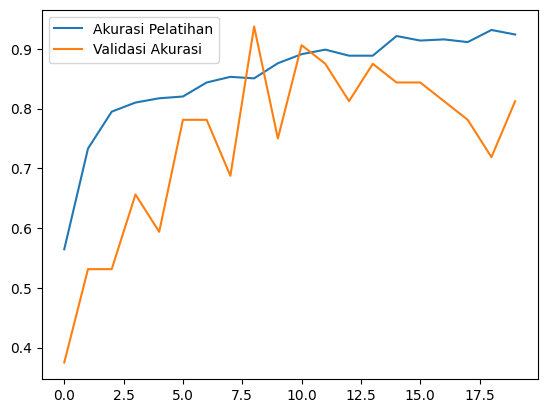

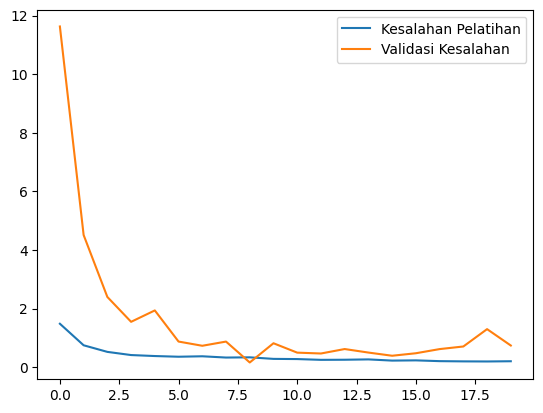

In [24]:
plt.plot(history.history["accuracy"],label="Akurasi Pelatihan")
plt.plot(history.history["val_accuracy"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=data_datatest,
    dir=path_datatest,
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 160 validated image filenames.


In [26]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

5/5 [==============================] - 34s 8s/step


In [27]:
predicted_classes=np.argmax(predict,axis=1)
predicted_classes

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1])

In [28]:
true_classes=np.array(data_datatest['categories'].replace(['moi','rajaampat',],[0,1]))
true_classes

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1])

In [29]:
class_labels=['0','1']
class_labels

['0', '1']

In [30]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[61, 29],
       [27, 43]])

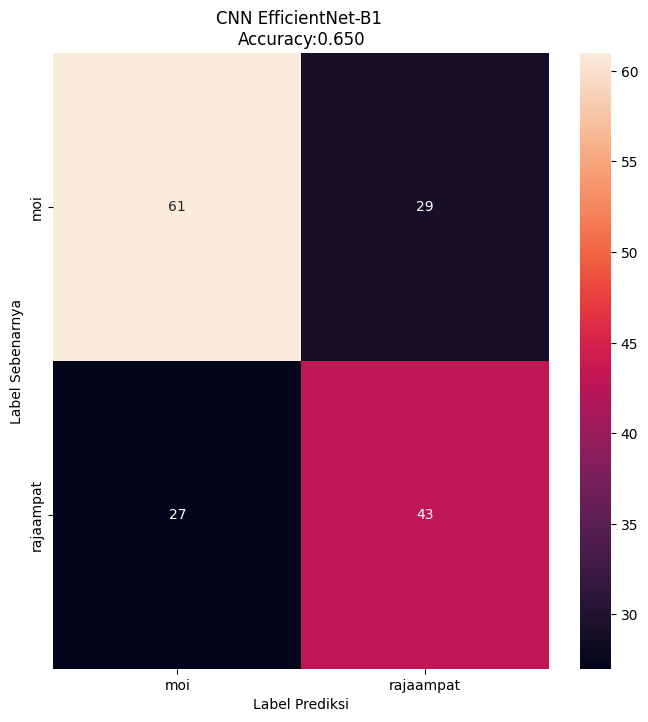

In [31]:
cm_df = pd.DataFrame(cm,
                     index = ['moi','rajaampat'],
                     columns = ['moi','rajaampat'])

plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('CNN EfficientNet-B1 \nAccuracy:{0:.3f}'.format(accuracy_score(true_classes, predicted_classes)))
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.show()

In [32]:
report=metrics.classification_report(true_classes, predicted_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.68      0.69        90
           1       0.60      0.61      0.61        70

    accuracy                           0.65       160
   macro avg       0.65      0.65      0.65       160
weighted avg       0.65      0.65      0.65       160



In [33]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)